# Clustering & Anomaly Detection – Traffic G3

**Project**: Traffic Analysis for Howest Campus (CTAI)  
**Team**: Hadi, Rares, Hamzzah  
**Date**: January 2026

## Objective
This notebook addresses **requirement 3** of our project proposal:
1. **Clustering**: Group similar traffic patterns to understand typical behavior.
2. **Anomaly Detection**: Identify unusual traffic situations, such as unexpectedly few cyclists in good weather or abnormal nighttime patterns.

We focus on **cyclist traffic on both key streets near campus**: Sintmartenslatemlaan and Graaf Karel de Goedelaan.

**Approach**: Train a single combined model on both streets together, then interpret results per street.

We use:
- **KMeans clustering** to discover pattern groups
- **IsolationForest** to flag anomalies

## 1. Import Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import pandas as pd


# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load and Explore Data

In [2]:
# Load the merged traffic and weather data
df = pd.read_csv('data/traffic_weather_merged.csv', parse_dates=['date'])

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nUnique streets: {df['street_name'].unique()}")
print("\n" + "="*60)
df.head()

Dataset shape: (3489, 33)

Date range: 2025-11-10 14:00:00+01:00 to 2026-01-27 15:00:00+01:00

Unique streets: ['Graaf Karel De Goedelaan' 'Sintmartenslatemlaan']



,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,night,heavy_lft,heavy_rgt,car_lft,car_rgt,bike_lft,bike_rgt,pedestrian_lft,pedestrian_rgt,night_lft,night_rgt,direction,car_speed_hist_0to70plus,car_speed_hist_0to120plus,timezone,v85,street_name,temperature_c,precipitation_mm,rain_mm,snowfall_cm,cloud_cover_pct,wind_speed_kmh,sunshine_duration_s
0,-1,9000009940,2025-11-10 14:00:00+01:00,hourly,0.499722,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Paris,NaN,Graaf Karel De Goedelaan,11.6,0.0,0.0,0.0,100,17.6,0.0
1,-1,9000009940,2025-11-10 15:00:00+01:00,hourly,0.999167,30.0,6.0,0.0,0.0,0.000000,3.0,27.0,0.0,6.0,0.0,0.0,0.0,0.0,0.000000,0.00000,1,"[33.3333333333, 16.6666666667, 0.0, 33.3333333...","[33.3333333333, 0.0, 0.0, 16.6666666667, 0.0, ...",Europe/Paris,65.5,Graaf Karel De Goedelaan,11.6,0.0,0.0,0.0,100,19.2,0.0
2,-1,9000009940,2025-11-10 16:00:00+01:00,hourly,0.999722,1.0,1.0,16.0,0.0,32.000000,1.0,0.0,0.0,1.0,14.0,2.0,0.0,0.0,14.000000,18.00000,1,"[0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0...",Europe/Paris,39.0,Graaf Karel De Goedelaan,11.1,0.0,0.0,0.0,100,20.5,0.0
3,-1,9000009940,2025-11-10 17:00:00+01:00,hourly,0.999444,0.0,0.0,0.0,0.0,376.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.000000,269.00000,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Paris,NaN,Graaf Karel De Goedelaan,10.9,0.1,0.1,0.0,100,19.2,0.0
4,-1,9000009940,2025-11-10 18:00:00+01:00,hourly,0.990278,0.0,0.0,0.0,0.0,146.027682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.532872,85.49481,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Paris,NaN,Graaf Karel De Goedelaan,10.9,0.1,0.1,0.0,100,18.7,0.0


In [3]:
# 2. Quick data quality check

print("Data info (columns + dtypes):")
print(df.dtypes)  # one line per column

print("\n" + "="*60)
print("Per-column missing values:\n")

missing = df.isnull().sum().to_frame(name="missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(df) * 100).round(2)

print(missing)


Data info (columns + dtypes):
instance_id                                      int64
segment_id                                       int64
date                         datetime64[ns, UTC+01:00]
interval                                        object
uptime                                         float64
heavy                                          float64
car                                            float64
bike                                           float64
pedestrian                                     float64
night                                          float64
heavy_lft                                      float64
heavy_rgt                                      float64
car_lft                                        float64
car_rgt                                        float64
bike_lft                                       float64
bike_rgt                                       float64
pedestrian_lft                                 float64
pedestrian_rgt                     

## 3. Focus on Cyclists at Both Key Streets

We filter the data to analyze cyclist patterns on the two main streets near campus: **Sintmartenslatemlaan** and **Graaf Karel de Goedelaan**.

In [4]:
# Filter for both key streets near campus
df_two_streets = df[df['street_name'].isin([
    'Sintmartenslatemlaan',
    'Graaf Karel de Goedelaan'
])].copy()

print(f"Filtered dataset shape: {df_two_streets.shape}")
print(f"Date range: {df_two_streets['date'].min()} to {df_two_streets['date'].max()}")
print(f"\nData per street:")
print(df_two_streets.groupby('street_name').size())

# Feature engineering: extract time components
df_two_streets['hour'] = df_two_streets['date'].dt.hour
df_two_streets['dayofweek'] = df_two_streets['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df_two_streets['is_weekend'] = (df_two_streets['dayofweek'] >= 5).astype(int)

# Encode street as numeric for the model
df_two_streets['street_id'] = df_two_streets['street_name'].astype('category').cat.codes

# Define target: cyclist count
df_two_streets['target_count'] = df_two_streets['bike']

print("\n✓ Feature engineering complete")
print(f"\nStreet encoding: {dict(enumerate(df_two_streets['street_name'].astype('category').cat.categories))}")
df_two_streets[['date', 'street_name', 'hour', 'dayofweek', 'is_weekend', 'target_count']].head(10)

Filtered dataset shape: (1615, 33)
Date range: 2025-11-21 09:00:00+01:00 to 2026-01-27 15:00:00+01:00

Data per street:
street_name
Sintmartenslatemlaan    1615
dtype: int64

✓ Feature engineering complete

Street encoding: {0: 'Sintmartenslatemlaan'}


,date,street_name,hour,dayofweek,is_weekend,target_count
260,2025-11-21 09:00:00+01:00,Sintmartenslatemlaan,9,4,0,4.0
261,2025-11-21 10:00:00+01:00,Sintmartenslatemlaan,10,4,0,11.0
263,2025-11-21 11:00:00+01:00,Sintmartenslatemlaan,11,4,0,16.0
266,2025-11-21 12:00:00+01:00,Sintmartenslatemlaan,12,4,0,30.0
267,2025-11-21 13:00:00+01:00,Sintmartenslatemlaan,13,4,0,19.0
269,2025-11-21 14:00:00+01:00,Sintmartenslatemlaan,14,4,0,21.0
271,2025-11-21 15:00:00+01:00,Sintmartenslatemlaan,15,4,0,15.0
273,2025-11-21 16:00:00+01:00,Sintmartenslatemlaan,16,4,0,27.0
275,2025-11-21 17:00:00+01:00,Sintmartenslatemlaan,17,4,0,0.0
278,2025-11-21 18:00:00+01:00,Sintmartenslatemlaan,18,4,0,0.0


## 4. Prepare Features for Clustering & Anomaly Detection

We select relevant features and handle missing values.

In [5]:
# Select features for clustering and anomaly detection
feature_cols = [
    'hour', 'dayofweek', 'is_weekend', 'street_id',
    'temperature_c', 'precipitation_mm', 'cloud_cover_pct',
    'target_count'
]


# Create feature matrix
df_features = df_two_streets[feature_cols].copy()

# Handle missing values (fill with 0 for simplicity)
df_features = df_features.fillna(0)

print(f"Feature matrix shape: {df_features.shape}")
print(f"\nMissing values after cleaning: {df_features.isnull().sum().sum()}")
print("\nFeature summary:")
df_features.describe()

Feature matrix shape: (1615, 8)

Missing values after cleaning: 0

Feature summary:


,hour,dayofweek,is_weekend,street_id,temperature_c,precipitation_mm,cloud_cover_pct,target_count
count,1615.000000,1615.000000,1615.000000,1615.0,1615.000000,1615.000000,1615.000000,1615.000000
mean,11.502167,3.019195,0.297214,0.0,5.140372,0.083901,75.840867,1.741765
std,6.910641,2.030499,0.457173,0.0,3.944901,0.341349,36.540976,3.796728
min,0.000000,0.000000,0.000000,0.0,-4.300000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,0.0,2.200000,0.000000,55.000000,0.000000
50%,12.000000,3.000000,0.000000,0.0,5.200000,0.000000,100.000000,0.000000
75%,17.000000,5.000000,1.000000,0.0,8.200000,0.000000,100.000000,2.000000
max,23.000000,6.000000,1.000000,0.0,14.300000,6.000000,100.000000,45.000000


In [6]:
# Standardize features for better clustering and anomaly detection
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features)

print(f"✓ Features standardized")
print(f"Scaled feature matrix shape: {features_scaled.shape}")

✓ Features standardized
Scaled feature matrix shape: (1615, 8)


## 5. Clustering Analysis (KMeans)

**Goal**: Group similar traffic patterns to understand typical behavior across both streets.

We train a single KMeans model with 4 clusters on the combined data to identify distinct patterns such as:
- Rush hour with high cyclist traffic
- Quiet nighttime periods
- Weekend leisure patterns
- Weather-dependent variations

The model learns from both streets together, allowing us to compare patterns between locations.

In [7]:
# Fit KMeans with 4 clusters on combined data
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_two_streets['cluster'] = kmeans.fit_predict(features_scaled)

print(f"✓ KMeans clustering complete with {n_clusters} clusters")
print(f"\nOverall cluster distribution:")
print(df_two_streets['cluster'].value_counts().sort_index())
print(f"\nCluster distribution per street:")
print(df_two_streets.groupby(['street_name', 'cluster']).size().unstack(fill_value=0))

✓ KMeans clustering complete with 4 clusters

Overall cluster distribution:
cluster
0    298
1    792
2    474
3     51
Name: count, dtype: int64

Cluster distribution per street:
cluster                 0    1    2   3
street_name                            
Sintmartenslatemlaan  298  792  474  51


In [8]:
# Analyze cluster characteristics - Overall
cluster_summary = df_two_streets.groupby('cluster').agg({
    'target_count': ['mean', 'std', 'count'],
    'hour': 'mean',
    'is_weekend': 'mean',
    'temperature_c': 'mean',
    'precipitation_mm': 'mean'
}).round(2)

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns]
cluster_summary = cluster_summary.rename(columns={
    'target_count_mean': 'Avg_Bikes',
    'target_count_std': 'Std_Bikes',
    'target_count_count': 'N_Hours',
    'hour_mean': 'Avg_Hour',
    'is_weekend_mean': 'Weekend_%',
    'temperature_c_mean': 'Avg_Temp_C',
    'precipitation_mm_mean': 'Avg_Rain_mm',
    'precipitation_mm_mean': 'Avg_Rain_mm'
})

print("Overall Cluster Characteristics:")
print("="*80)
print(cluster_summary)

# Analyze per street
print("\n\nCluster Characteristics Per Street:")
print("="*80)
cluster_per_street = df_two_streets.groupby(['street_name', 'cluster']).agg({
    'target_count': ['mean', 'count'],
    'hour': 'mean',
    'is_weekend': 'mean'
}).round(2)

cluster_per_street.columns = ['_'.join(col).strip() for col in cluster_per_street.columns]
cluster_per_street = cluster_per_street.rename(columns={
    'target_count_mean': 'Avg_Bikes',
    'target_count_count': 'N_Hours',
    'hour_mean': 'Avg_Hour',
    'is_weekend_mean': 'Weekend_%'
})
cluster_per_street

Overall Cluster Characteristics:
         Avg_Bikes  Std_Bikes  N_Hours  Avg_Hour  Weekend_%  Avg_Temp_C  \
cluster                                                                   
0             1.02       2.74      298     11.65       0.00        2.28   
1             2.36       4.51      792     11.33       0.00        6.54   
2             1.27       3.01      474     11.49       1.00        4.49   
3             0.71       1.26       51     13.39       0.12        6.18   

         Avg_Rain_mm  
cluster               
0               0.01  
1               0.04  
2               0.04  
3               1.58  


Cluster Characteristics Per Street:


Avg_Bikes  N_Hours  Avg_Hour  Weekend_%
street_name          cluster                                         
Sintmartenslatemlaan 0             1.02      298     11.65       0.00
                     1             2.36      792     11.33       0.00
                     2             1.27      474     11.49       1.00
                     3             0.71       51     13.39       0.12

### Visualize Clusters

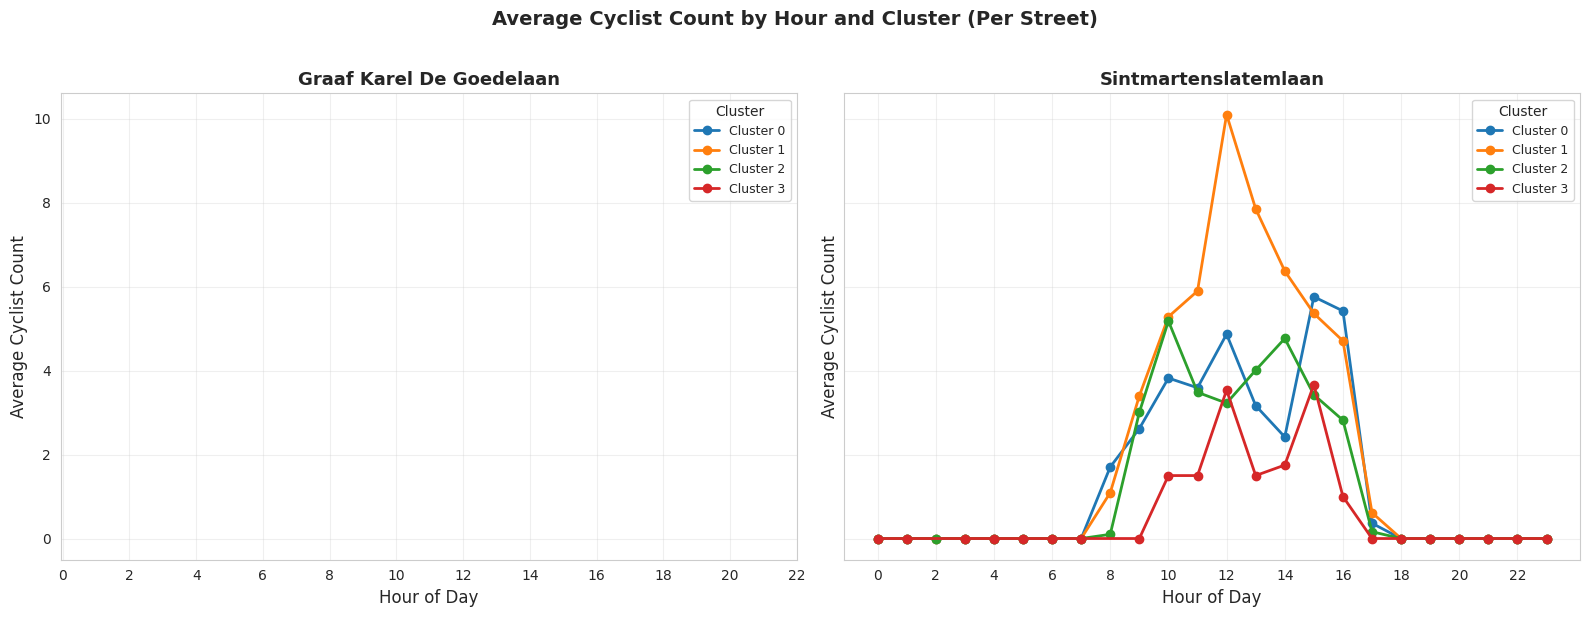

✓ Clusters show distinct temporal patterns across both streets


In [9]:
# Average cyclist count by hour for each cluster - separated by street
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, street in enumerate(['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']):
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    cluster_hourly = street_data.groupby(['cluster', 'hour'])['target_count'].mean().reset_index()
    
    ax = axes[idx]
    for cluster in range(n_clusters):
        data = cluster_hourly[cluster_hourly['cluster'] == cluster]
        ax.plot(data['hour'], data['target_count'], marker='o', label=f'Cluster {cluster}', linewidth=2)
    
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Cyclist Count', fontsize=12)
    ax.set_title(f'{street.title()}', fontsize=13, fontweight='bold')
    ax.legend(title='Cluster', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xticks(range(0, 24, 2))

plt.suptitle('Average Cyclist Count by Hour and Cluster (Per Street)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Clusters show distinct temporal patterns across both streets")

/tmp/ipykernel_361503/3690917952.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=street_data, x='cluster', y='target_count', palette='Set2', ax=ax)


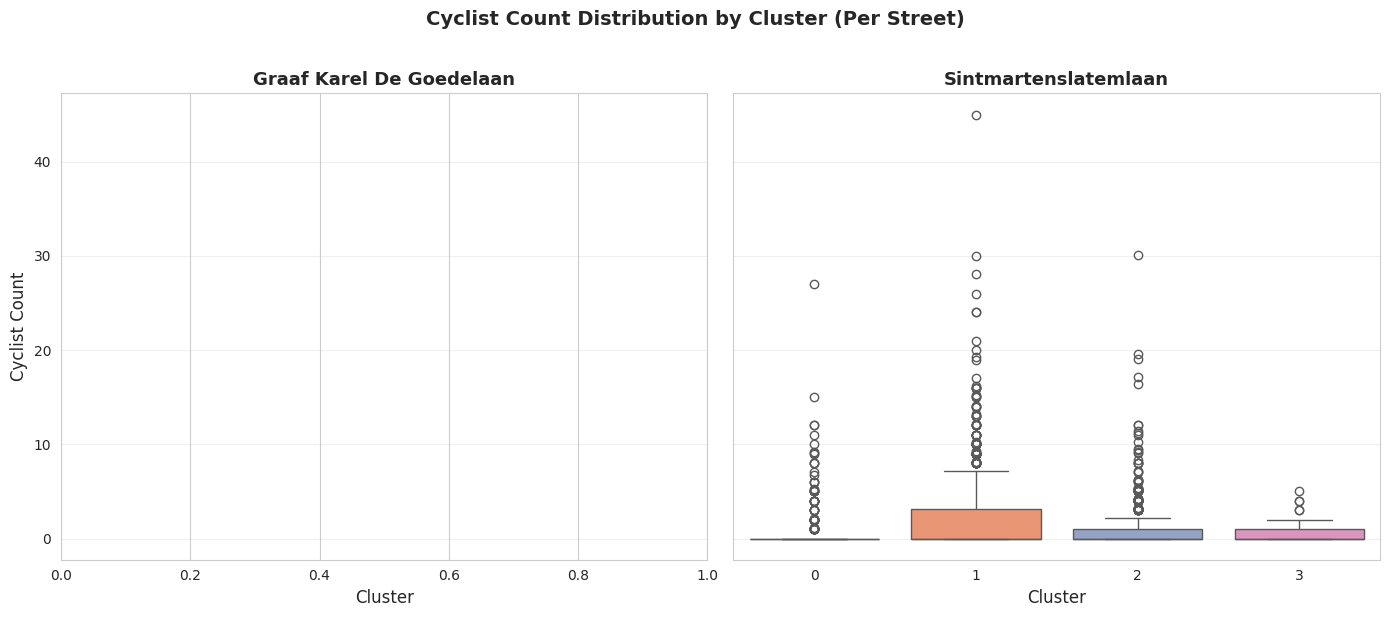

In [10]:
# Box plot: cyclist count distribution by cluster - faceted by street
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for idx, street in enumerate(['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']):
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    ax = axes[idx]
    
    import seaborn as sns
    sns.boxplot(data=street_data, x='cluster', y='target_count', palette='Set2', ax=ax)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Cyclist Count', fontsize=12)
    ax.set_title(f'{street.title()}', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Cyclist Count Distribution by Cluster (Per Street)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Anomaly Detection (IsolationForest)

**Goal**: Identify unusual traffic situations that deviate from typical patterns across both streets.

We train a single IsolationForest model on the combined data to flag anomalies such as:
- Unexpectedly few cyclists during good weather
- Abnormal nighttime traffic
- Other irregular patterns

The model learns normal patterns from both streets, then we can examine anomalies per street.

In [11]:
# Train IsolationForest with 2% contamination rate on combined data
contamination_rate = 0.02
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
anomaly_predictions = iso_forest.fit_predict(features_scaled)

# Convert predictions: -1 = anomaly, 1 = normal
df_two_streets['is_anomaly'] = (anomaly_predictions == -1)

n_anomalies = df_two_streets['is_anomaly'].sum()
print(f"✓ Anomaly detection complete")
print(f"\nOverall anomalies detected: {n_anomalies} ({n_anomalies/len(df_two_streets)*100:.2f}%)")
print(f"Normal observations: {(~df_two_streets['is_anomaly']).sum()}")

print("\nAnomalies per street:")
anomaly_per_street = df_two_streets.groupby('street_name')['is_anomaly'].agg(['sum', 'mean'])
anomaly_per_street.columns = ['Count', 'Rate']
anomaly_per_street['Rate'] = (anomaly_per_street['Rate'] * 100).round(2)
print(anomaly_per_street)

✓ Anomaly detection complete

Overall anomalies detected: 33 (2.04%)
Normal observations: 1582

Anomalies per street:
                      Count  Rate
street_name                      
Sintmartenslatemlaan     33  2.04


### Top Anomalies

In [12]:
# Extract anomalies - sorted by LOW cyclist count (ascending)
anomalies = df_two_streets[df_two_streets['is_anomaly']].copy()
anomalies = anomalies.sort_values('target_count', ascending=True)  # Changed to ascending

# Select relevant columns for display
anomaly_cols = [
    'date', 'street_name', 'hour', 'target_count', 'temperature_c', 'precipitation_mm', 
    'cloud_cover_pct', 'is_weekend', 'cluster'
]

top_anomalies = anomalies[anomaly_cols].head(20)

print("Top 20 Anomalies (sorted by LOWEST cyclist count):")
print("="*100)
top_anomalies

Top 20 Anomalies (sorted by LOWEST cyclist count):


,date,street_name,hour,target_count,temperature_c,precipitation_mm,cloud_cover_pct,is_weekend,cluster
1019,2025-12-07 05:00:00+01:00,Sintmartenslatemlaan,5,0.000000,8.6,3.6,100,1,3
3379,2026-01-25 09:00:00+01:00,Sintmartenslatemlaan,9,0.000000,0.3,4.2,88,1,3
2587,2026-01-08 21:00:00+01:00,Sintmartenslatemlaan,21,0.000000,3.7,2.4,100,0,3
1045,2025-12-07 18:00:00+01:00,Sintmartenslatemlaan,18,0.000000,13.6,0.5,100,1,2
1043,2025-12-07 17:00:00+01:00,Sintmartenslatemlaan,17,0.000000,13.1,0.8,100,1,2
2593,2026-01-09 00:00:00+01:00,Sintmartenslatemlaan,0,0.000000,7.7,1.9,100,0,3
663,2025-11-29 19:00:00+01:00,Sintmartenslatemlaan,19,0.000000,10.0,1.8,100,1,3
2340,2026-01-03 17:00:00+01:00,Sintmartenslatemlaan,17,0.000000,0.8,2.8,84,1,3
422,2025-11-24 18:00:00+01:00,Sintmartenslatemlaan,18,0.000000,5.6,6.0,100,0,3
2608,2026-01-09 07:00:00+01:00,Sintmartenslatemlaan,7,0.000000,6.1,4.0,98,0,3


### Focus: Low Cyclist Count in Good Weather

This is particularly interesting for our project – identifying times when cycling conditions were favorable (no rain, reasonable temperature) but cyclist counts were unexpectedly low.

In [13]:
# Filter anomalies: good weather but low cyclist count
good_weather_anomalies = anomalies[
    (anomalies['precipitation_mm'] == 0) &  # No rain
    (anomalies['temperature_c'] >= 10) &    # Reasonable temperature
    (anomalies['temperature_c'] <= 25) &    # Not too hot
    (anomalies['target_count'] < anomalies['target_count'].median())  # Below median
].copy()

print(f"Anomalies with GOOD WEATHER but LOW cyclist count: {len(good_weather_anomalies)}")
print("="*100)
print("\nThese could indicate:")
print("- Special events or road closures")
print("- Holiday periods when campus is quiet")
print("- Data quality issues")
print("- Other external factors affecting cycling")

print("\nBreakdown per street:")
print(good_weather_anomalies.groupby('street_name').size())
print("\nTop:")
print("="*100)
good_weather_anomalies[anomaly_cols].head(15)

Anomalies with GOOD WEATHER but LOW cyclist count: 0

These could indicate:
- Special events or road closures
- Holiday periods when campus is quiet
- Data quality issues
- Other external factors affecting cycling

Breakdown per street:
Series([], dtype: int64)

Top:


,date,street_name,hour,target_count,temperature_c,precipitation_mm,cloud_cover_pct,is_weekend,cluster


In [14]:
# Compute hourly medians per street for context
hourly_median = df_two_streets.groupby(['street_name', 'hour'])['target_count'].median()

# Map each anomaly to its expected median for that street+hour
good_weather_anomalies['hourly_median'] = good_weather_anomalies.set_index(['street_name', 'hour']).index.map(hourly_median)

# Calculate ratio: how far below typical is this anomaly?
good_weather_anomalies['ratio_to_median'] = (good_weather_anomalies['target_count'] / good_weather_anomalies['hourly_median']).round(2)

print("Good Weather Anomalies Compared to Street-Specific Hourly Medians:")
print("="*100)
print("Ratio < 1.0 means below typical for that street+hour")
print("="*100)

display_cols = anomaly_cols + ['hourly_median', 'ratio_to_median']
good_weather_anomalies[display_cols].head(15)

TypeError: Expected numeric dtype, got object instead.

### Validate Anomalies Against Street-Specific Hourly Medians

To ensure these anomalies are truly unusual, we compare them against typical hourly cyclist counts for each street.

### Visualize Anomalies

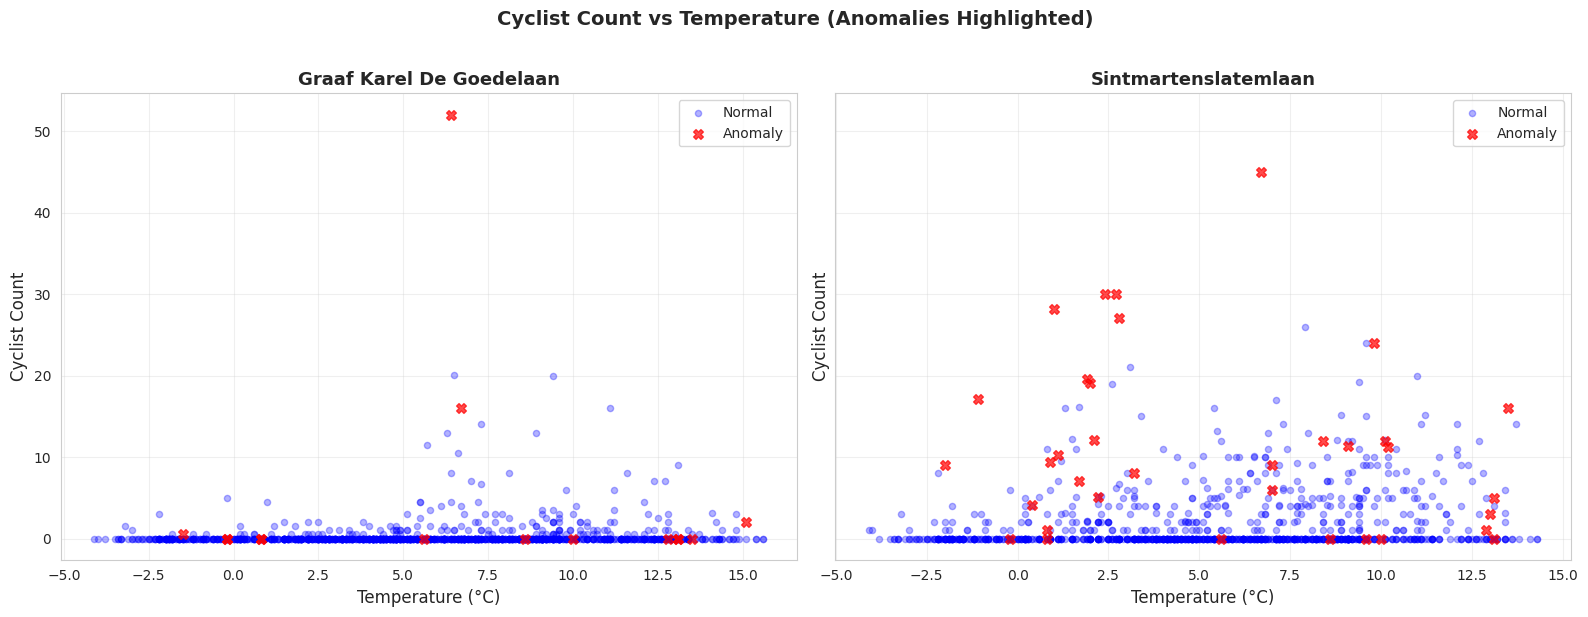

In [ ]:
# Scatter plot: cyclist count vs temperature, highlighting anomalies - per street
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, street in enumerate(['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']):
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    normal = street_data[~street_data['is_anomaly']]
    anomaly = street_data[street_data['is_anomaly']]
    
    ax = axes[idx]
    ax.scatter(normal['temperature_c'], normal['target_count'], 
               alpha=0.3, s=20, c='blue', label='Normal')
    ax.scatter(anomaly['temperature_c'], anomaly['target_count'], 
               alpha=0.7, s=50, c='red', marker='X', label='Anomaly')
    
    ax.set_xlabel('Temperature (°C)', fontsize=12)
    ax.set_ylabel('Cyclist Count', fontsize=12)
    ax.set_title(f'{street.title()}', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Cyclist Count vs Temperature (Anomalies Highlighted)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

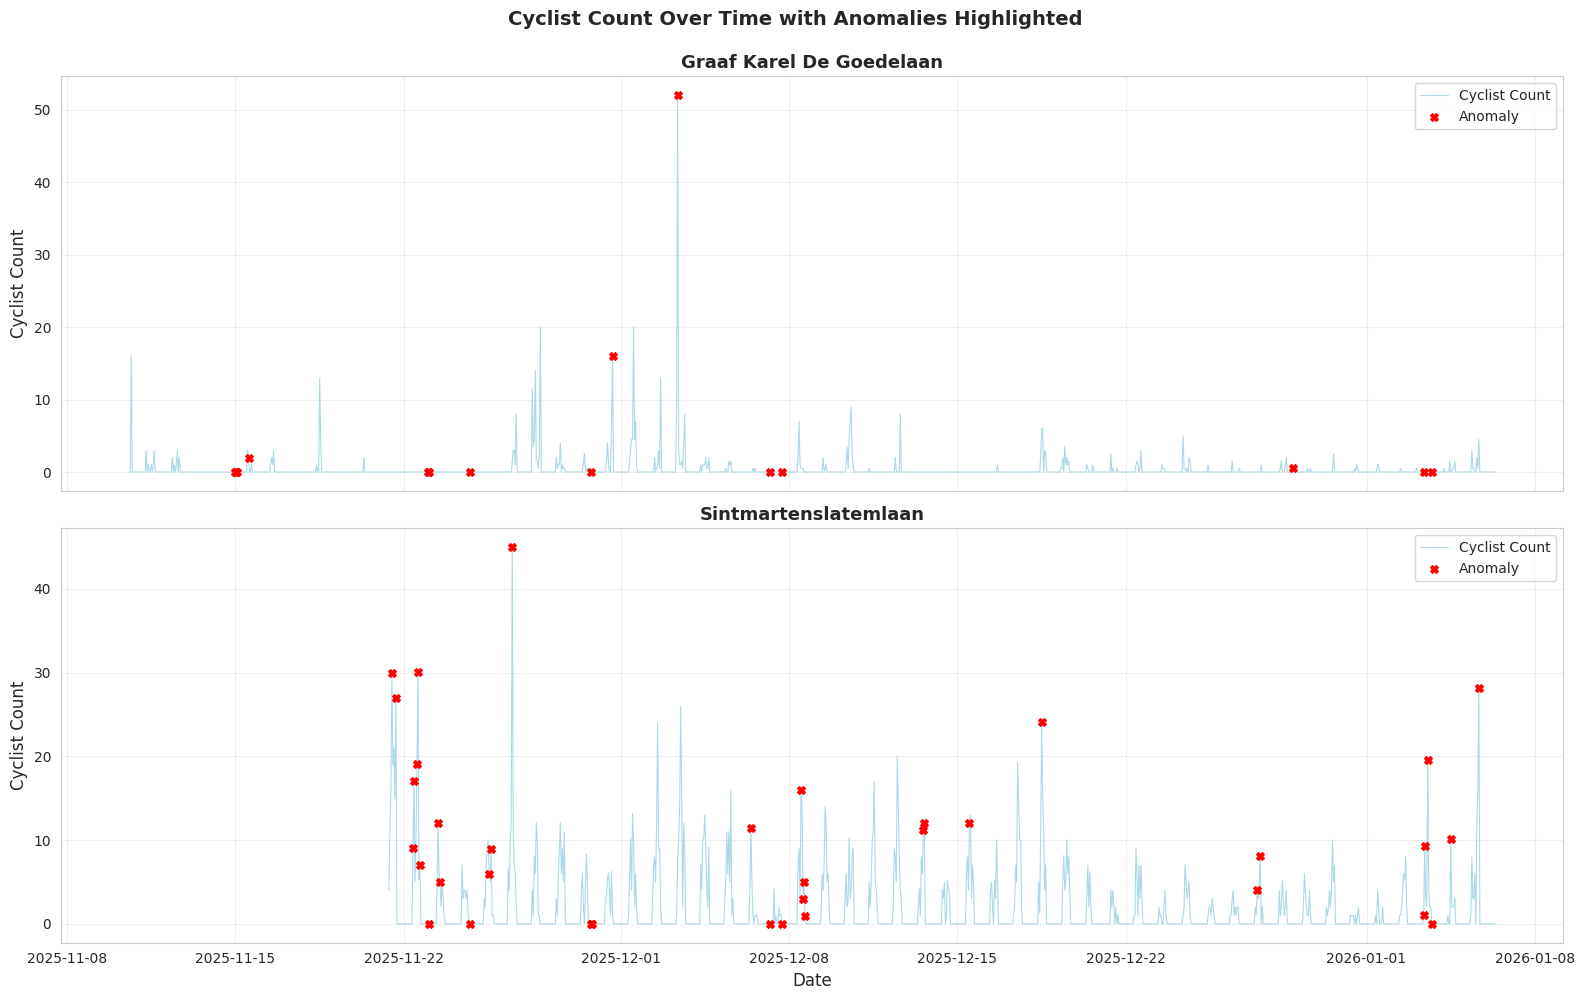

In [ ]:
# Time series view: cyclist count over time with anomalies marked - per street
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

for idx, street in enumerate(['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']):
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    anomaly_dates = street_data[street_data['is_anomaly']]
    
    ax = axes[idx]
    ax.plot(street_data['date'], street_data['target_count'], 
            color='lightblue', linewidth=0.8, label='Cyclist Count')
    ax.scatter(anomaly_dates['date'], anomaly_dates['target_count'], 
               color='red', s=30, marker='X', label='Anomaly', zorder=5)
    
    ax.set_ylabel('Cyclist Count', fontsize=12)
    ax.set_title(f'{street.title()}', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

axes[1].set_xlabel('Date', fontsize=12)
plt.suptitle('Cyclist Count Over Time with Anomalies Highlighted', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Interpretation & Project Alignment

### How This Satisfies Project Requirements

**Requirement: Group similar traffic patterns (Clustering)**
- We trained a **single combined KMeans model** on both streets together
- This identifies 4 distinct traffic patterns that apply across both locations
- We can then interpret clusters per street to understand:
  - How Sintmartenslatemlaan differs from Graaf Karel de Goedelaan
  - Whether rush hour patterns, weekend behavior, and weather effects are similar or different
- This combined approach is more robust than separate models and enables direct comparison

**Requirement: Detect anomalies**
- We trained a **single combined IsolationForest** on both streets
- The model flags unusual observations (~2% of data overall)
- Key findings include:
  - Hours with unexpectedly low cyclist counts despite good weather
  - Validated against **street-specific hourly medians** to ensure anomalies are truly unusual for each location
  - Abnormal patterns that may indicate events, holidays, or data issues
  - These anomalies help identify situations requiring further investigation

### Practical Value for Howest
1. **Safety**: Anomalies during expected high-traffic times could indicate infrastructure problems
2. **Planning**: Understanding cluster patterns helps optimize campus access timing for both streets
3. **Policy**: "Good weather, low cyclists" anomalies reveal opportunities to promote cycling
4. **Data Quality**: Extreme anomalies may flag sensor or data collection issues
5. **Comparative Insights**: The combined model allows direct comparison between the two streets' patterns

## 8. Summary Statistics

In [ ]:
# Generate final summary
print("="*80)
print("CLUSTERING & ANOMALY DETECTION SUMMARY")
print("="*80)
print(f"\n📊 Dataset: Combined cyclist traffic from both streets")
print(f"   Streets: Sintmartenslatemlaan & Graaf Karel de Goedelaan")
print(f"   Total observations: {len(df_two_streets)}")
print(f"   Date range: {df_two_streets['date'].min().date()} to {df_two_streets['date'].max().date()}")

print(f"\n🔍 Clustering Results (Combined Model):")
print(f"   Number of clusters: {n_clusters}")
print(f"   Overall cluster distribution:")
for i in range(n_clusters):
    count = (df_two_streets['cluster'] == i).sum()
    pct = count / len(df_two_streets) * 100
    print(f"      Cluster {i}: {count} hours ({pct:.1f}%)")

print(f"\n   Per-street cluster distribution:")
for street in ['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']:
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    print(f"\n   {street.title()}:")
    for i in range(n_clusters):
        count = (street_data['cluster'] == i).sum()
        pct = count / len(street_data) * 100
        print(f"      Cluster {i}: {count} hours ({pct:.1f}%)")

print(f"\n⚠️ Anomaly Detection Results (Combined Model):")
print(f"   Total anomalies: {n_anomalies} ({n_anomalies/len(df_two_streets)*100:.2f}%)")
print(f"   Per street:")
for street in ['Graaf Karel de Goedelaan', 'Sintmartenslatemlaan']:
    street_data = df_two_streets[df_two_streets['street_name'] == street]
    street_anomalies = street_data['is_anomaly'].sum()
    street_pct = street_anomalies / len(street_data) * 100
    print(f"      {street.title()}: {street_anomalies} ({street_pct:.2f}%)")

print(f"\n   Good weather + low cyclist anomalies: {len(good_weather_anomalies)}")
print(f"      (validated against street-specific hourly medians)")

print("="*80)

CLUSTERING & ANOMALY DETECTION SUMMARY

📊 Dataset: Combined cyclist traffic from both streets
   Streets: Sintmartenslatemlaan & Graaf Karel de Goedelaan
   Total observations: 2467
   Date range: 2025-11-10 to 2026-01-06

🔍 Clustering Results (Combined Model):
   Number of clusters: 4
   Overall cluster distribution:
      Cluster 0: 127 hours (5.1%)
      Cluster 1: 708 hours (28.7%)
      Cluster 2: 1137 hours (46.1%)
      Cluster 3: 495 hours (20.1%)

   Per-street cluster distribution:

   Graaf Karel De Goedelaan:
      Cluster 0: 13 hours (1.0%)
      Cluster 1: 383 hours (28.1%)
      Cluster 2: 708 hours (51.9%)
      Cluster 3: 259 hours (19.0%)

   Sintmartenslatemlaan:
      Cluster 0: 114 hours (10.3%)
      Cluster 1: 325 hours (29.4%)
      Cluster 2: 429 hours (38.9%)
      Cluster 3: 236 hours (21.4%)

⚠️ Anomaly Detection Results (Combined Model):
   Total anomalies: 50 (2.03%)
   Per street:
      Graaf Karel De Goedelaan: 15 (1.10%)
      Sintmartenslatemlaan: 35 (

Cluster 0 – peak cyclist traffic: daytime / rush‑hour periods with clearly higher cyclist counts on both streets.

Clusters 1–3 – quiet or off‑peak regimes: hours with very few cyclists, often at night, early morning, or under less favorable conditions.


In [ ]:
# Export clustering models and results for dashboard
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Export clustering models
joblib.dump(kmeans, "../models/kmeans_model.pkl")
joblib.dump(iso_forest, "../models/isolation_forest_model.pkl")
joblib.dump(scaler, "../models/scaler_clustering.pkl")

# Export feature columns and other metadata for clustering
clustering_metadata = {
    'feature_cols': feature_cols,
    'n_clusters': n_clusters,
    'contamination_rate': contamination_rate,
    'street_encoding': dict(enumerate(df_two_streets['street_name'].astype('category').cat.categories))
}
joblib.dump(clustering_metadata, "../models/clustering_metadata.pkl")

# Export the processed clustering data with results
df_clustering_results = df_two_streets.copy()
df_clustering_results.to_parquet("../models/clustering_results.parquet")

print("✅ Exported clustering models and data to models/ directory")
print(f"📊 Clustering models: KMeans ({n_clusters} clusters), IsolationForest ({contamination_rate} contamination)")
print(f"📈 Results saved for {len(df_two_streets)} observations")
print(f"🎯 Anomalies detected: {df_two_streets['is_anomaly'].sum()} ({df_two_streets['is_anomaly'].sum()/len(df_two_streets)*100:.2f}%)")

✅ Exported clustering models and data to models/ directory
📊 Clustering models: KMeans (4 clusters), IsolationForest (0.02 contamination)
📈 Results saved for 2467 observations
🎯 Anomalies detected: 50 (2.03%)
